In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow, keras, keras_tuner
import keras as krs
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, MaxPooling1D, Dropout, Bidirectional, Conv1D, Flatten, TextVectorization
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import SGD
from keras.utils import to_categorical
import keras_tuner

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import OneHotEncoder

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [140]:
intense = json.loads(open("intense.json", 'r', encoding='utf-8').read())

In [5]:
intense['intents'][0]

{'tag': 'greetings',
 'patterns': ['Привіт',
  'Вітаю',
  'Здоровенькі',
  'Добрий день',
  'Добрий вечір',
  'Добрий ранок',
  'Доброго дня',
  'Hi',
  'Hello',
  'Howdy',
  'Hi there',
  'Hello there',
  'Hey',
  'Hiya',
  'Good to see you again',
  'Long time no see',
  'Good morning!',
  'Good afternoon!',
  'Good evening!',
  'Hey there!',
  'Hey friend!',
  'Hi friend!',
  'Hey buddy!',
  'Hi buddy!',
  'Hey pal!',
  'Hi pal!',
  'Hey dude!',
  'Hi dude!',
  'Hey man!',
  'Hi man!',
  'Hey sir!',
  "Hi ma'am!",
  'Hi sir!',
  "Hello ma'am!",
  'Hello sir!'],
 'response': ['Привіт!', 'Вітаю, дообродію!', 'Доброго дня, пане!']}

In [6]:
nltk.download('stopwords')
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krivi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krivi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
stopwords_en = stopwords.words("english")

In [8]:
#stopwords_ua = pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords'])
#stopwords_ua = list(stopwords_ua.stopwords)
stopwords_ua = [ "до", "про", "з", "в", "з", "чи"]

In [9]:
stopwords_ua

['до', 'про', 'з', 'в', 'з', 'чи']

In [10]:
stopwords_en

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
ALL_STOPWORDS = stopwords_ua + stopwords_en

In [12]:
def preprocess_sentence(text):
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)

    # remove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)

    # remove numbers
    text = re.sub(r'[0-9]', '', text)

    # remove html tags
    text = re.sub(r'<.*?>',' ',text) 

    # remove stopwords
    text = text.lower()
    sentence_words = text.split()
    resultWords = [word for word in sentence_words if word not in ALL_STOPWORDS]
    text = ' '.join(resultWords)

    return text


In [141]:
sentences = []
labels = []
tags = set()
words = []
responses = {}

for intent in intense['intents']:
    tags.add(intent['tag'])

    responses[intent['tag']] = intent['response']
    for pattern in intent['patterns']:
        pattern = preprocess_sentence(pattern)

        sentences.append(pattern)
        labels.append(intent['tag'])

In [142]:
responses["greetings"]

['Привіт!',
 'Вітаю, дообродію!',
 'Доброго дня, пане!',
 'Hi',
 'Hello',
 'Hello, my friend!',
 'How can I help?',
 'Greetings',
 'How many I assist you?',
 'Nice to meet you',
 'Pleased to make your acquaintance',
 'What brings you here today?',
 "How's your day going so far?",
 'How are you doing?',
 "What's new?",
 'Is there anything I can help you with?',
 'How may I assist you today?',
 'Nice to see you again',
 "It's good to be in touch with you",
 "What's happening?",
 'How have you been?',
 'Great to see you!',
 "What's on your mind?"]

In [14]:
sentences

['привіт',
 'вітаю',
 'здоровенькі',
 'добрий день',
 'добрий вечір',
 'добрий ранок',
 'доброго дня',
 'hi',
 'hello',
 'howdy',
 'hi',
 'hello',
 'hey',
 'hiya',
 'good see',
 'long time see',
 'good morning',
 'good afternoon',
 'good evening',
 'hey',
 'hey friend',
 'hi friend',
 'hey buddy',
 'hi buddy',
 'hey pal',
 'hi pal',
 'hey dude',
 'hi dude',
 'hey man',
 'hi man',
 'hey sir',
 'hi maam',
 'hi sir',
 'hello maam',
 'hello sir',
 'розкажи себе',
 'хто ти',
 'що ти',
 '',
 'tell',
 'ти можеш допомогти',
 'допомога',
 'твої функції',
 'що ти вмієш',
 'help',
 'need assistance',
 '',
 'guide',
 '',
 'дякую',
 'я ціную це',
 'допомогло дякую',
 'thanks',
 'thank',
 'appreciate',
 'бувай',
 'бувай здоров',
 'на все добре',
 'всього найкращого',
 'вечора',
 'завтра',
 'прощавай',
 'па',
 'папа',
 'bye',
 'goodbye',
 'see later',
 'take care',
 'farewell',
 'nice day',
 'good one',
 'catch later',
 'розкажи анекдот',
 'анекдот',
 'розміши',
 'підніми настрій',
 'мені трохи сумно

In [15]:
def show_data_wordcloud(data):
    data_str = ' '.join(data)
    plt.figure(figsize=(14,6))
    wordcloud = WordCloud(width=1000,height=500).generate(data_str)
    plt.imshow(wordcloud,interpolation='bilinear',cmap='magma')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Wordcloud',fontsize= 25,color='Red')
    plt.show()

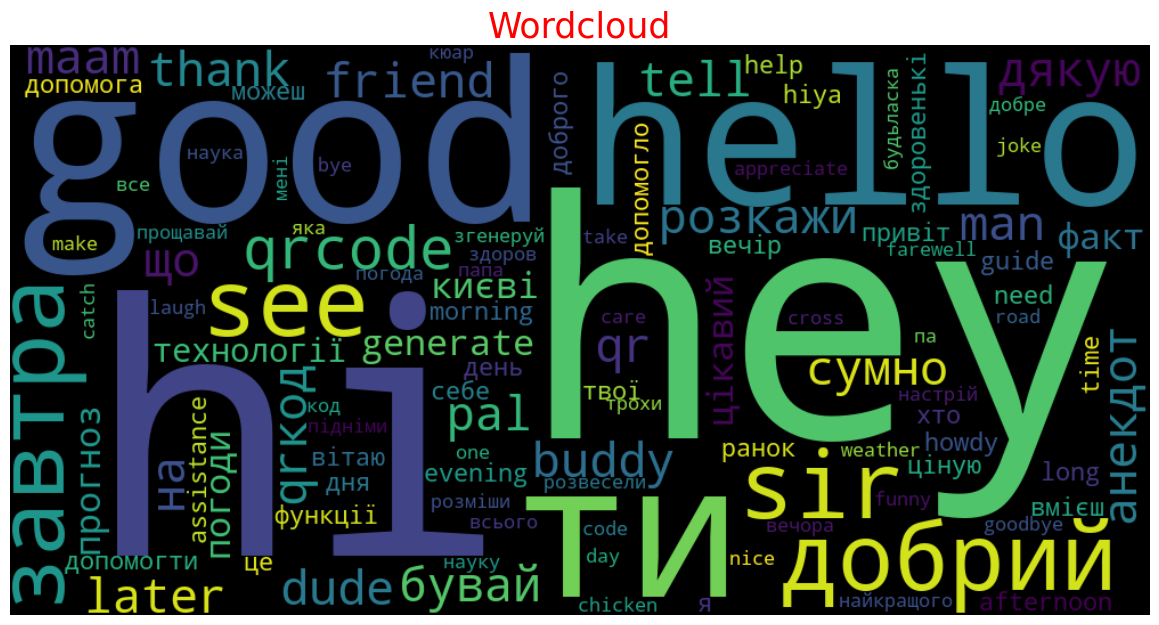

In [16]:
show_data_wordcloud(sentences)

In [17]:
train_sentences = np.array(sentences)
train_labels = np.array(labels)

print(f'Type of train sentense: {type(train_sentences)}; shape of the container: {train_sentences.shape}')
print(f'Type of train labels: {type(train_labels)}; shape of the container: {train_labels.shape}')

Type of train sentense: <class 'numpy.ndarray'>; shape of the container: (99,)
Type of train labels: <class 'numpy.ndarray'>; shape of the container: (99,)


# Tokenize sentences

In [18]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=100, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)

    return tokenizer

In [19]:
NUM_WORDS = 111
OOV_TOKEN = '<OOV>'

In [20]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 111 words

<OOV> token included in vocabulary


In [21]:
word_index

{'<OOV>': 1,
 'hi': 2,
 'hey': 3,
 'good': 4,
 'hello': 5,
 'ти': 6,
 'добрий': 7,
 'see': 8,
 'sir': 9,
 'завтра': 10,
 'qrcode': 11,
 'friend': 12,
 'buddy': 13,
 'pal': 14,
 'dude': 15,
 'man': 16,
 'maam': 17,
 'розкажи': 18,
 'що': 19,
 'tell': 20,
 'дякую': 21,
 'бувай': 22,
 'на': 23,
 'later': 24,
 'анекдот': 25,
 'сумно': 26,
 'qrкод': 27,
 'qr': 28,
 'generate': 29,
 'прогноз': 30,
 'погоди': 31,
 'києві': 32,
 'цікавий': 33,
 'факт': 34,
 'технології': 35,
 'привіт': 36,
 'вітаю': 37,
 'здоровенькі': 38,
 'день': 39,
 'вечір': 40,
 'ранок': 41,
 'доброго': 42,
 'дня': 43,
 'howdy': 44,
 'hiya': 45,
 'long': 46,
 'time': 47,
 'morning': 48,
 'afternoon': 49,
 'evening': 50,
 'себе': 51,
 'хто': 52,
 'можеш': 53,
 'допомогти': 54,
 'допомога': 55,
 'твої': 56,
 'функції': 57,
 'вмієш': 58,
 'help': 59,
 'need': 60,
 'assistance': 61,
 'guide': 62,
 'я': 63,
 'ціную': 64,
 'це': 65,
 'допомогло': 66,
 'thanks': 67,
 'thank': 68,
 'appreciate': 69,
 'здоров': 70,
 'все': 71,
 'д

In [22]:
vectorize_layer = TextVectorization(output_mode="int", output_sequence_length=5)

vectorize_layer.adapt(train_sentences)

vectorize_layer.vocabulary_size()

112

# Padding sequences

In [23]:
def get_padding_sequences(tokenizer, sentences, padding, maxlen=5):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)

    return padded_sequences

In [24]:
PADDING = 'post'

In [25]:
# train data
X_train = get_padding_sequences(tokenizer, train_sentences, PADDING)

print(f"First sentences: {train_sentences[0]}")
print(f"First padded sequence looks like this: \n\n{X_train[0]}\n")
print(f"Numpy array of train sequences has shape: {X_train.shape}\n")
print(f"This means there are {X_train.shape[0]} sequences in total and each one has a size of {X_train.shape[1]}")


First sentences: привіт
First padded sequence looks like this: 

[36  0  0  0  0]

Numpy array of train sequences has shape: (99, 5)

This means there are 99 sequences in total and each one has a size of 5


In [26]:
vocab_size=len(tokenizer.word_index) + 1
maxlen=X_train.shape[1]
print(f'Vocabulary size: {vocab_size}')
print(f'Maxlen: {maxlen}')

Vocabulary size: 112
Maxlen: 5


# Transform labels to One-Hot encoding

In [27]:
unique_labels = np.unique(labels)
classes = len(unique_labels)
print(classes)

10


In [28]:
train_labels

array(['greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'greetings', 'greetings', 'greetings', 'greetings', 'greetings',
       'about', 'about', 'about', 'about', 'about', 'help', 'help',
       'help', 'help', 'help', 'help', 'help', 'help', 'help', 'thanks',
       'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'goodbye',
       'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye',
       'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye',
       'goodbye', 'goodbye', 'goodbye', 'goodbye', 'joke', 'joke', 'joke',
       'joke', 'joke', 'joke', 'joke', 'joke', 'joke', 'joke', 'jo

In [29]:
encoder = OneHotEncoder(handle_unknown="ignore")
y_train = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()

In [30]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [31]:
X_train.shape

(99, 5)

In [32]:
y_train.shape

(99, 10)

# Model training

In [33]:
def build_model():
    model = Sequential()
    model.add(krs.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=maxlen))

    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128)))

    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=128, activation="relu"))

    model.add(Dense(classes, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [34]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 5)                 0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 5, 32)             3584      
                                                                 
 bidirectional (Bidirection  (None, 5, 256)            164864    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

In [35]:
history = model.fit(train_sentences, y_train, epochs=200, batch_size=8, verbose=1)

Epoch 1/200
13/13 [==============================] - 8s 11ms/step - loss: 2.2497 - accuracy: 0.2929
Epoch 2/200
13/13 [==============================] - 0s 10ms/step - loss: 1.9963 - accuracy: 0.3535
Epoch 3/200
13/13 [==============================] - 0s 10ms/step - loss: 1.9113 - accuracy: 0.3535
Epoch 4/200
13/13 [==============================] - 0s 10ms/step - loss: 1.8418 - accuracy: 0.3535
Epoch 5/200
13/13 [==============================] - 0s 10ms/step - loss: 1.5742 - accuracy: 0.3535
Epoch 6/200
13/13 [==============================] - 0s 10ms/step - loss: 1.4271 - accuracy: 0.4646
Epoch 7/200
13/13 [==============================] - 0s 9ms/step - loss: 1.2852 - accuracy: 0.4949
Epoch 8/200
13/13 [==============================] - 0s 10ms/step - loss: 1.1199 - accuracy: 0.5354
Epoch 9/200
13/13 [==============================] - 0s 9ms/step - loss: 1.0344 - accuracy: 0.6162
Epoch 10/200
13/13 [==============================] - 0s 9ms/step - loss: 0.9201 - accuracy: 0.6768
Ep

In [36]:
def plot_model_history(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

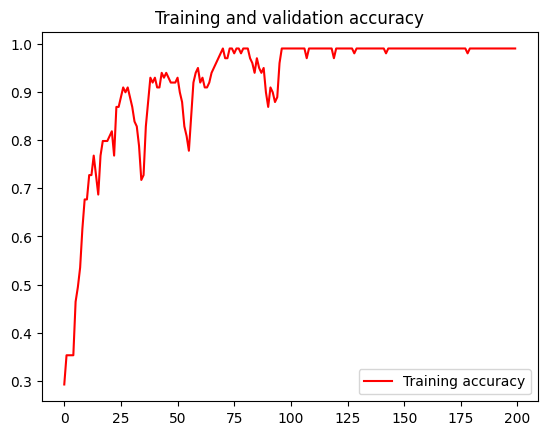

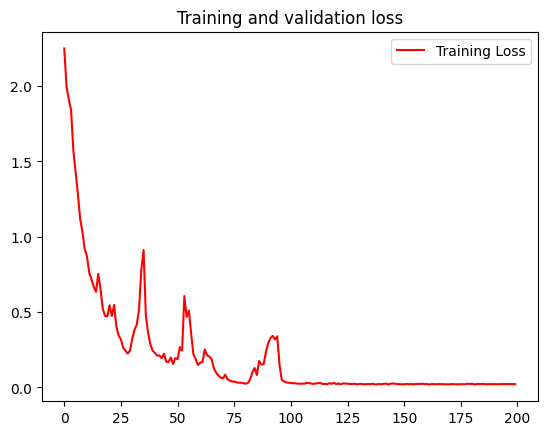

In [37]:
plot_model_history(history)

In [38]:
PADDING

'post'

In [39]:
tokenizer.word_index

{'<OOV>': 1,
 'hi': 2,
 'hey': 3,
 'good': 4,
 'hello': 5,
 'ти': 6,
 'добрий': 7,
 'see': 8,
 'sir': 9,
 'завтра': 10,
 'qrcode': 11,
 'friend': 12,
 'buddy': 13,
 'pal': 14,
 'dude': 15,
 'man': 16,
 'maam': 17,
 'розкажи': 18,
 'що': 19,
 'tell': 20,
 'дякую': 21,
 'бувай': 22,
 'на': 23,
 'later': 24,
 'анекдот': 25,
 'сумно': 26,
 'qrкод': 27,
 'qr': 28,
 'generate': 29,
 'прогноз': 30,
 'погоди': 31,
 'києві': 32,
 'цікавий': 33,
 'факт': 34,
 'технології': 35,
 'привіт': 36,
 'вітаю': 37,
 'здоровенькі': 38,
 'день': 39,
 'вечір': 40,
 'ранок': 41,
 'доброго': 42,
 'дня': 43,
 'howdy': 44,
 'hiya': 45,
 'long': 46,
 'time': 47,
 'morning': 48,
 'afternoon': 49,
 'evening': 50,
 'себе': 51,
 'хто': 52,
 'можеш': 53,
 'допомогти': 54,
 'допомога': 55,
 'твої': 56,
 'функції': 57,
 'вмієш': 58,
 'help': 59,
 'need': 60,
 'assistance': 61,
 'guide': 62,
 'я': 63,
 'ціную': 64,
 'це': 65,
 'допомогло': 66,
 'thanks': 67,
 'thank': 68,
 'appreciate': 69,
 'здоров': 70,
 'все': 71,
 'д

In [165]:
test_sentence = "Добрий вечір!"
prep_test_data = preprocess_sentence(test_sentence)
print(f"Preprocessed test data: {prep_test_data}")

Preprocessed test data: добрий вечір


In [166]:
predictions = model.predict([prep_test_data])

1/1 [==============================] - 0s 39ms/step


In [167]:
predictions

array([[7.8762339e-09, 3.3498411e-06, 9.9999642e-01, 1.4832697e-08,
        2.7188329e-07, 7.4162885e-09, 7.4793469e-09, 3.7074757e-10,
        7.3404491e-09, 7.9337399e-09]], dtype=float32)

In [168]:
predictions.argmax()

2

In [169]:
np.sum(predictions)

1.0

In [170]:
predicted_tag = encoder.inverse_transform(predictions)[0,0]
print(predicted_tag)

greetings


# Calculate similarity and choose response

In [47]:
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)

In [49]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, 32)

In [171]:
vectorized_test = vectorize_layer(prep_test_data)
embedded_test = embedding_layer(vectorized_test)

In [172]:
vectorized_test

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 8, 76,  0,  0,  0], dtype=int64)>

In [173]:
print(f"User input sentence: {test_data}.")

similarities = []
for response in responses[predicted_tag]:
    vectorized_response = vectorize_layer(response)
    embedded_response = embedding_layer(vectorized_response)
    sim = abs(cosine_loss(embedded_test, embedded_response))
    similarities.append(sim)
    print(f'Similarity with response {response}: {sim}.')

User input sentence: ['Tell me a joke!'].
Similarity with response Привіт!: 0.5590969920158386.
Similarity with response Вітаю, дообродію!: 0.6121681928634644.
Similarity with response Доброго дня, пане!: 0.3888475298881531.
Similarity with response Hi: 0.5718042254447937.
Similarity with response Hello: 0.5744947195053101.
Similarity with response Hello, my friend!: 0.44741344451904297.
Similarity with response How can I help?: 0.23658029735088348.
Similarity with response Greetings: 0.5590969920158386.
Similarity with response How many I assist you?: 0.15088500082492828.
Similarity with response Nice to meet you: 0.3386076092720032.
Similarity with response Pleased to make your acquaintance: 0.13640430569648743.
Similarity with response What brings you here today?: 0.15088500082492828.
Similarity with response How's your day going so far?: 0.10321340709924698.
Similarity with response How are you doing?: 0.3046460747718811.
Similarity with response What's new?: 0.6121681928634644.
Si

In [174]:
best_sim = max(similarities)
print(f"Best similarity {best_sim}")

Best similarity 0.6121681928634644


In [175]:
best_sim_index = similarities.index(best_sim)

In [176]:
responses[predicted_tag][best_sim_index]

'Вітаю, дообродію!'